In [ ]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [ ]:
!mkdir {Config().data_path()}/'mnist'
!wget -r http://deeplearning.net/data/mnist/mnist.pkl.gz -d {Config().data_path()}/'mnist'

DEBUG output created by Wget 1.19.4 on linux-gnu.

Reading HSTS entries from /root/.wget-hsts
URI encoding = ‘UTF-8’
URI encoding = ‘UTF-8’
Enqueuing http://deeplearning.net/data/mnist/mnist.pkl.gz at depth 0
Queue count 1, maxcount 1.
[IRI Enqueuing ‘http://deeplearning.net/data/mnist/mnist.pkl.gz’ with ‘UTF-8’
Dequeuing http://deeplearning.net/data/mnist/mnist.pkl.gz at depth 0
Queue count 0, maxcount 1.
Converted file name 'deeplearning.net/data/mnist/mnist.pkl.gz' (UTF-8) -> 'deeplearning.net/data/mnist/mnist.pkl.gz' (UTF-8)
--2020-09-01 07:12:47--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Caching deeplearning.net => 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
Created socket 3.
Releasing 0x0000564a1f2b8460 (new refcount 1).

---request begin---
GET /data/mnist/mnist.pkl.gz HTTP/1.1
User-Agent: Wget/1.19.4 (linux-gnu)
Accept: */*
Accept-Encoding: identity
Host: d

In [ ]:
path = Config().data_path()
#path = '/content/deeplearning.net/data/mnist/mnist.pkl.gz'

In [ ]:
path.ls()

[PosixPath('/root/.fastai/data/mnist')]

In [ ]:
!dir {path}/'mnist/deeplearning.net/data/mnist'

mnist.pkl.gz


In [ ]:
# loading pickled gzip directly into an array

with gzip.open(path/'mnist/deeplearning.net/data/mnist/mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

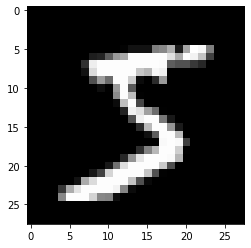

In [ ]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [ ]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

#I may as well create a variable with the number of things I have which we normally call n. Here, we use c to mean the number of columns (that's not a great name for it sorry). So there we are. Then the y not surprisingly the minimum value is 0 and the maximum value is 9 because that's the actual number we're gonna predict.

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) # creating bias
def mse(y_hat, y): return ((y_hat-y)**2).mean() # mse function
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [ ]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [ ]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

# it will give you mini batches

#Once you have a dataset, 
#then you can use a little bit of convenience by calling DataBunch.
#create and what that is going to do is it's going to create data loaders for you. 
#A data loader is something which you don't say I want the first thing or the fifth thing, you just say I want the "next" thing, and it will give you a mini batch of whatever size you asked for. Specifically it'll give you the X and the y of a mini batch. So if I just grab the next of the iterator (this is just standard Python). Here's my training data loader (data.train_dl) that DataBunch.create creates for you. You can check that as you would expect the X is 64 by 784 because there's 784 pixels flattened out, 64 in a mini batch and the Y is just 64 numbers -
# they are things we're trying to predict.

(torch.Size([64, 784]), torch.Size([64]))

In [ ]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [ ]:
model = Mnist_Logistic().cuda()

# Because we're doing stuff ourself a little bit 
#we have to put the weight matrices (i.e. the parameters) 
#onto the GPU manually. So just type .cuda() to do that.

In [ ]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [ ]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [ ]:
model(x).shape

torch.Size([64, 10])

In [ ]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [ ]:
lr=2e-2

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
# . We're going to come back to this loss function in a moment but we can't really use MSE for this because we're not trying to see "how close are you". 
# Did you predict 3 and actually it was 4, gosh you were really close. 
# No, 3 is just as far away from 4 as 0 is away from 4 when you're trying to predict what number did somebody draw. 
# So we're not going to use MSE, we're going to use cross-entropy loss

def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [ ]:
losses = [update(x,y,lr) for x,y in data.train_dl]

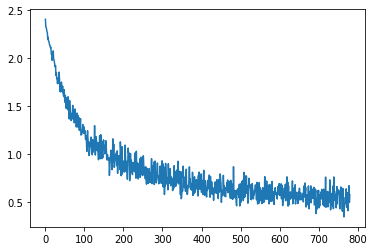

In [ ]:
plt.plot(losses);

In [ ]:
'''
Now that we've got this update function, 
we could replace this Mnist_Logistic 
with MNIST neural networketwork 
and build a neural network from scratch.
'''

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)


"""
Now we just need two linear layers.
 In the first one, we could use a weight matrix of size 50. 
 We need to make sure that the second linear layer has an input
  of size 50 so it matches. 
  The final layer has to have an output of size 10 because 
  that's the number of classes we're predicting. 
So now our forward just goes:

do a linear layer
calculate ReLU
do a second linear layer
Now we've actually created a neural net from scratch. I mean we didn't write nn.Linear but you can write it yourself or you could do the matrices directly - you know how to.

Again we can go model dot CUDA, and then we can calculate losses for the exact same update function, there it goes
"""

"\nNow we just need two linear layers.\n In the first one, we could use a weight matrix of size 50. \n We need to make sure that the second linear layer has an input\n  of size 50 so it matches. \n  The final layer has to have an output of size 10 because \n  that's the number of classes we're predicting. \nSo now our forward just goes:\n\ndo a linear layer\ncalculate ReLU\ndo a second linear layer\nNow we've actually created a neural net from scratch. I mean we didn't write nn.Linear but you can write it yourself or you could do the matrices directly - you know how to.\n\nAgain we can go model dot CUDA, and then we can calculate losses for the exact same update function, there it goes\n"

In [ ]:
model = Mnist_NN().cuda()

In [ ]:
losses = [update(x,y,lr) for x,y in data.train_dl]

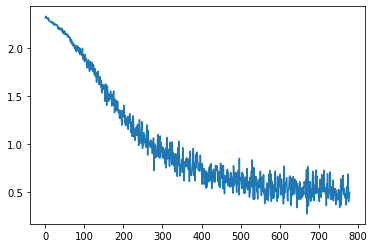

In [ ]:
plt.plot(losses);

In [ ]:
model = Mnist_NN().cuda()

In [ ]:
# changing update function with something other than SGD

def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [51]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]
# correct value = 1e-3

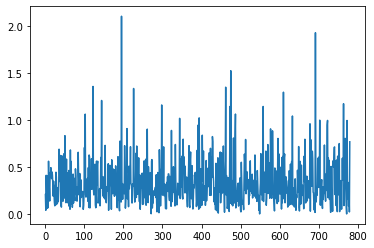

In [52]:
plt.plot(losses);

In [ ]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)
# learner dows whatever we did for you automatically

In [ ]:
%debug

> /usr/lib/python3.6/gzip.py(163)__init__()
    161             mode += 'b'
    162         if fileobj is None:
--> 163             fileobj = self.myfileobj = builtins.open(filename, mode or 'rb')
    164         if filename is None:
    165             filename = getattr(fileobj, 'name', '')

ipdb> dir
<built-in function dir>
--KeyboardInterrupt--
ipdb> exit


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


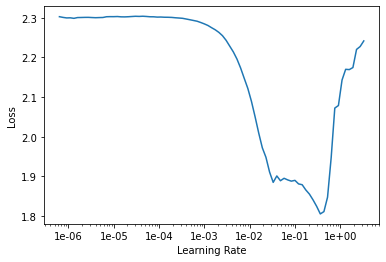

In [53]:
learn.lr_find()
learn.recorder.plot()

# lr_find actually finds you learning rate to the batch

In [54]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.171251,0.134421,0.961000,00:05


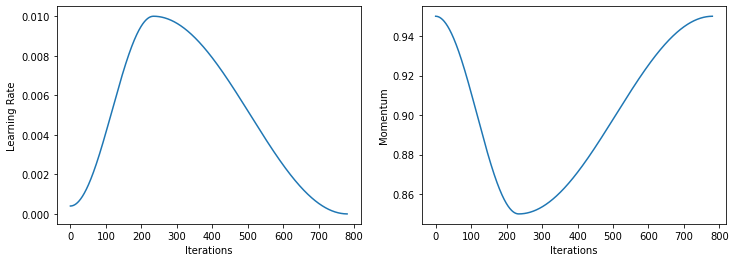

In [55]:
learn.recorder.plot_lr(show_moms=True)

# we need to anneal te=he learning rate at later iterations
# the momentum is more when learning rate is high

# this is what it does when we call fit_one_cycle function

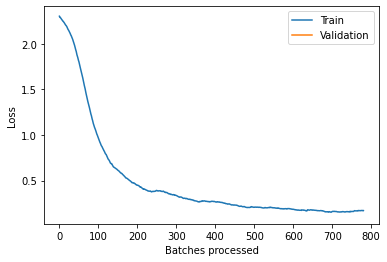

In [56]:
learn.recorder.plot_losses()

## fin